# Use Geometric Center of Building to Cluster

## Import Processed Centroid Data

In [5]:
import numpy as np
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
import matplotlib.pyplot as plt

In [6]:
rsd_ctr = np.genfromtxt('rsd_array_GeometricCentroids.csv', delimiter=',')
assert len(rsd_ctr) == 2454

In [7]:
# ms = ms(bandwidth=bandwidth, bin_seeding=True)
ms = MeanShift(bandwidth = 700) # bandwidth is radius

# bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
ms.fit(rsd_ctr)
labels = ms.labels_
num_clusters = len(np.unique(labels)) 
# np.unique() -> how many unique elements there are
print('num of clusters:', len(np.unique(labels)))
print('center location: ', ms.cluster_centers_)

num of clusters: 13
center location:  [[-11003648.33099699   2236203.06789322]
 [-11002989.54308781   2235859.74816779]
 [-11004087.23203178   2238350.2609857 ]
 [-11002764.7894786    2236829.86010023]
 [-11004524.52566712   2233978.16196052]
 [-11004010.45297033   2234513.89356726]
 [-11001660.42275263   2235055.05694726]
 [-11006257.4932012    2236662.24537854]
 [-11003302.34265636   2234819.85130134]
 [-11001896.40203712   2233626.32486572]
 [-11004610.56044462   2232351.04097536]
 [-11000429.93404995   2234691.66890067]
 [-11006075.38449723   2233124.09142184]]



|bandwidth|No. of clusters|
|--|--|
|10e2|567|
|400|34|
|500|21|
|700|13|
|1000|5|


## Graphing

In [8]:
# Generate visually distance colors

def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    
    return tuple([(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors])

# Reorganize the RGB data to hex
colors = []
for i in range(num_clusters+1):
    pass
#     colors.append('#%02x%02x%02x' % get_spaced_colors(num_clusters + 1)[1:][i])
colors = get_spaced_colors(num_clusters + 1)

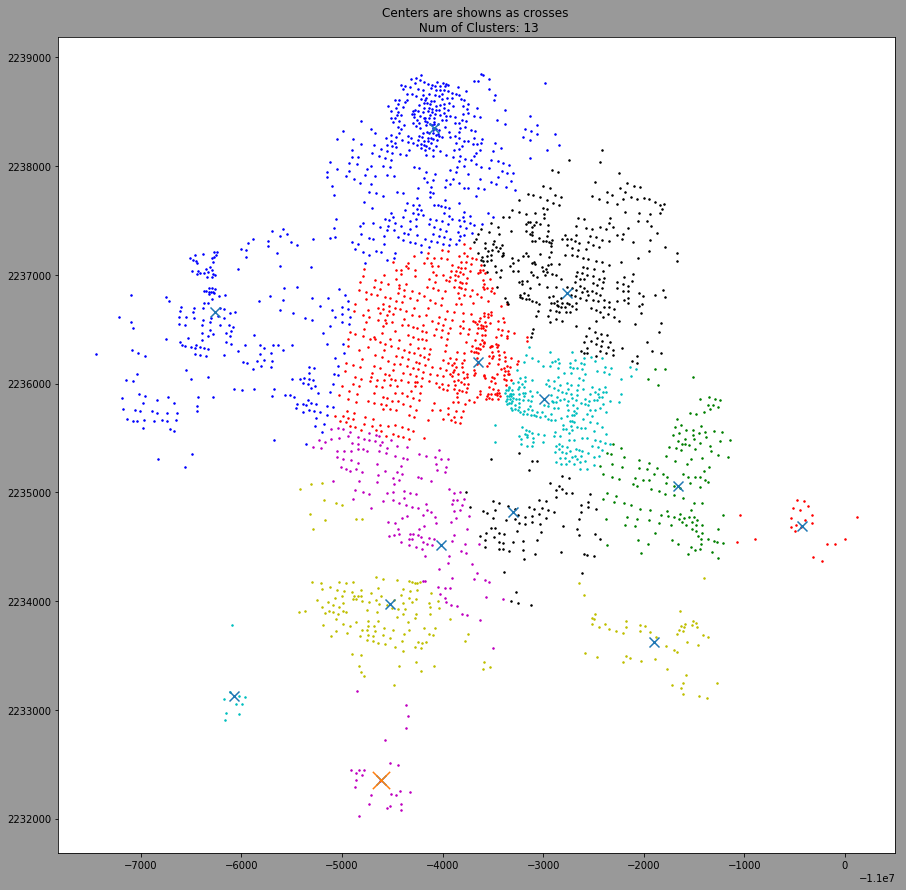

In [85]:
plt.figure(figsize = (15, 15), facecolor = '.6')
colors = ['r.', 'c.', 'b.', 'k.', 'y.', 'm.', 'g.', 'b.', 'k.', 'y.', 'm.']*1000

for i in range(len(rsd_ctr)):
    plt.plot(rsd_ctr[i][0], rsd_ctr[i][1],  colors[labels[i]] , markersize = 3)

# plt.plot(rsd_ctr[i][0], rsd_ctr[i][1], colors[labels[i]], markersize = 1)

# paint center points
plt.scatter(ms.cluster_centers_[:,0], ms.cluster_centers_[:,1],
           marker = 'x', s = 100, linewidths = 0.3, zorder =10)

plt.title("Centers are showns as crosses \n Num of Clusters: %d" % len(np.unique(labels)))
plt.show()

# Analyzing Clusters - Area

For each cluster, produce its total area, built area, and number of structures, and other relevant info

In [94]:
import numpy as np
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape, LineString
import pandas as pd

In [95]:
rawMap = fiona.open('Data/Residences.shp')

In [96]:
# assort all the geoPy objects in the geoMap list
geoMap = []
for i in range(len(rawMap)):
    if rawMap[i]['geometry'] == None:
        print(i, 'is None')
    else:
        try:
            geoMap.append(Polygon(shape(rawMap[i]['geometry'])))
        except:
            print(i, 'has error')
assert len(geoMap) == len(rsd_ctr)

2447 has error
2448 is None


In [119]:
# dfArea is a DataFrame that contain the area of each building center point
dfArea = pd.DataFrame( columns = ['area', 'cluster'])
dfArea.area = [m.area for m in geoMap]
dfArea.cluster = labels

In [98]:
# Setup the result DataFrame
Results = pd.DataFrame(columns = 
['number_of_buildings', 'total_area', 'built_area', 'building_density',
 'max_area', 'min_area', 'mean_area', 'Gini_coefficient' ])

#### Calculate number_of_buildings, built_area, max_area, min_area, mean_area

In [117]:
# add data for cluster_number, number_of_buildings, total_area
Results.number_of_buildings = [len(dfArea[dfArea.cluster == i]) for i in range(num_clusters) ]
Results.built_area = [ sum(dfArea[dfArea.cluster == i].area) for i in range(num_clusters) ]
Results.max_area = [ max(dfArea[dfArea.cluster == i].area) for i in range(num_clusters) ]
Results.min_area = [ min(dfArea[dfArea.cluster == i].area) for i in range(num_clusters) ]
Results.mean_area = [ Results.total_area[i]/Results.number_of_buildings[i] for i in range(num_clusters) ]


#### Calculate Gini_coefficient

In [100]:
# Calculate Gini Coefficient for each cluster
def gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

Results.Gini_coefficient = [ gini(np.asarray(dfArea[dfArea.cluster == i].area)) for i in range(num_clusters) ]


#### Calculate total area of a cluster

In [101]:
# Calculate total area of each cluster region
# use the area convexHull of all center in the cluster
# http://scipy.github.io/devdocs/generated/scipy.spatial.ConvexHull.html
grouped_ctr = [[] for i in range(num_clusters)]
for i in range(len(rsd_ctr)):
    grouped_ctr[labels[i]].append(rsd_ctr[i])

In [102]:
# each item in convexhulls is a ConvexHull object consisted of the cluster
from scipy.spatial import ConvexHull

convexhulls = []
for i in range(num_clusters):
    convexhulls.append(ConvexHull(grouped_ctr[i]) )

Results.total_area = [ i.area for i in  convexhulls]

#### Calculate built_area and building_density

In [103]:
Results.built_area = [
    sum(dfArea[dfArea.cluster == i].area) for i in range(num_clusters)
]

In [104]:
Results.building_density = [
    Results.built_area[i]/Results.total_area[i] for i in range(num_clusters)
]

#### Calculate a total row

This table is the result of analyzing all these clusters. The index columns on the left indicates info for each cluster. Row no. 13 is done on the entire map <br/>
Illustration:  <br/>
built_area**: total area of building in the cluster <br/>
total_area**: total area of the cluster, measured by the area of the smallest convex hull that contain all center points of buildings in the cluster <br/>
**building_density**: built_area/total_area. Possibly due to different algorithms of the packages I used, the unit is wrong. However, I manually checked that the density here is a correct characterization the building density on the graph. So, qualitative comparisons can be made. <br/>
**max/min/mean_area**: max/min/mean area of all the buildings in each cluster <br/>
**Gini_coefficient**: the gini coefficient for all the areas of buildings in the cluster 

In [118]:
Results.append({
    'number_of_buildings': len(rsd_ctr), 'total_area': sum(Results.total_area), 
    'built_area': sum(dfArea.area), 'max_area': max(dfArea.area), 'min_area': min(dfArea.area),
    'mean_area': sum(dfArea.area)/sum(Results.total_area), 'Gini_coefficient': gini(np.asarray(dfArea.area)),
    'building_density': sum(dfArea.area)/sum(Results.total_area)
}, ignore_index=True)

,number_of_buildings,total_area,built_area,building_density,max_area,min_area,mean_area,Gini_coefficient
0,513.0,5861.876518,1.174244e+06,200.318744,34636.313970,55.488462,11.426660,0.427845
1,260.0,4053.111467,4.221737e+05,104.160395,6901.475497,86.017667,15.588890,0.406283
2,430.0,6435.667508,8.178157e+05,127.075511,8642.726669,164.650867,14.966669,0.365771
3,346.0,6132.803011,7.589574e+05,123.753752,39001.939774,70.984685,17.724864,0.453753
4,140.0,5904.669144,2.475158e+05,41.918661,9660.637601,150.072405,42.176208,0.432078
5,165.0,5894.232909,4.217162e+05,71.547251,11589.404899,210.013861,35.722624,0.386609
6,153.0,5086.652597,4.009693e+05,78.827739,10101.771716,212.324013,33.246095,0.382241
7,250.0,7497.611854,5.286180e+05,70.504854,9015.895048,153.730146,29.990447,0.407428
8,86.0,4158.540859,2.490079e+05,59.878680,8390.473770,367.524257,48.355126,0.385736
9,53.0,4313.744562,6.338127e+04,14.692865,2941.664150,202.873390,81.391407,0.296460


### Histogram for the allocation of areas in a cluster

Text(0.5, 1.0, 'asdf')

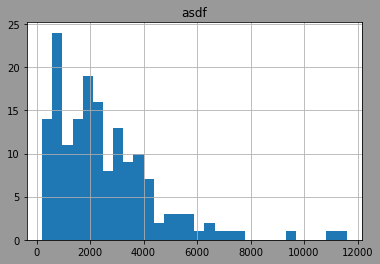

In [156]:

i = 5 # change i to desired cluster number to view 
plt.figure(facecolor = '.6')
hist_fig = dfArea[dfArea.cluster == i].area.hist(bins = 30).get_figure()
plt.title('asdf')
# dfArea.area.dropna().plot(kind='kde',xlim=(0,5*10e3), style='r--')

# Analyzing Clusters - Priphery

Measure the relevance of phriphery/area (or regularness) of each building